# 다중 회귀분석


***타겟 변수 : adr_1 변수에 대한 설명***

adr은 해당 레코드의 숙박팀의 1일 평균 사용금액을 말한다. : Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

adr_1은 이를 총 숙박인원수로 나누어 1인당 1일 평균 사용금액을 계산해낸 파생변수이다.

: 해당 adr_1과 유의미한 양의 상관관계를 가지는 변수를 알아내어 1일당 고매출액의 마케팅 타겟을 선정하고,
ADR을 예측하는 모델을 설계하는 것이 목적




  #### 파생 가능 주제 : 
  
어떤 속성이 adr와 유의미한 상관관계를 가지는가? 
-> 어떤 속성을 가진 타겟을 마케팅 대상으로 선정해야 매출액을 증대시킬 수 있을까? 등

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

''''''
df_ht = pd.read_csv('hotel_bookings.csv')
''''''
df_ht_lr = df_ht.drop(['company','agent','reservation_status','reservation_status_date','country'
                       ,'arrival_date_day_of_month'
                       ,'arrival_date_week_number',
                       'previous_bookings_not_canceled'], axis = 1)


''''''
df_ht_lr = df_ht_lr.dropna()


''''''

''

In [10]:
df_ht_lr.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,0,0,2,0.0,0,...,0,C,C,3,No Deposit,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,July,0,0,2,0.0,0,...,0,C,C,4,No Deposit,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,July,0,1,1,0.0,0,...,0,A,C,0,No Deposit,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,July,0,1,1,0.0,0,...,0,A,A,0,No Deposit,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,July,0,2,2,0.0,0,...,0,A,A,0,No Deposit,0,Transient,98.0,0,1


# 전처리

In [11]:
# 취소한 데이터는 해당 모델에 무의미하다고 판단하여 제외
df_ht_lr = df_ht_lr[df_ht_lr['is_canceled'] == 0]

In [12]:
#1
df_ht_lrp = df_ht_lr[df_ht_lr['adults'] < 5]

#+ 2 수행을 위한 총 인원변수 추가
    #+ 10인 이상의 이상값 제거
df_ht_lrp['total_guests'] = df_ht_lr['adults'] + df_ht_lr['babies'] + df_ht_lr['children']
df_ht_lrp = df_ht_lrp[df_ht_lrp['total_guests'] < 10]
#2
df_ht_lrp['adr_1'] = df_ht_lrp['adr'] // df_ht_lrp['total_guests']

    #2+
df_ht_lrp = df_ht_lrp.replace([np.inf, -np.inf], np.nan)
df_ht_lrp = df_ht_lrp.dropna()


#3 adr_1 이 0보다 작거나 같은 경우, 무의미한 데이터로 간주하여 삭제한다. & 200초과인 경우 이상치로 간주하여 제거
df_ht_lrp = df_ht_lrp[df_ht_lrp['adr_1'] > 0]

df_ht_lrp = df_ht_lrp[df_ht_lrp['adr_1'] < 200] 



Text(0.5, 1.0, 'boxenplot on adr_1')

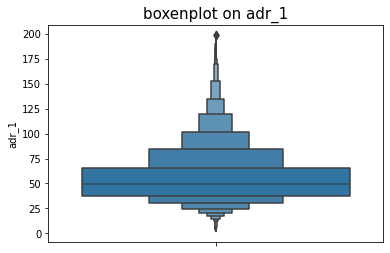

In [13]:
# adr_1의 분포를 보여주는 boxenplot
sns.boxenplot(data=df_ht_lrp, y='adr_1')

plt.title('boxenplot on adr_1',fontsize=15)

In [14]:
#불필요 변수 드랍
df_ht_lrp_mid = df_ht_lrp.drop(['previous_cancellations','reserved_room_type','days_in_waiting_list',
                                'is_canceled',
                                'adr'],
                               axis=1)

df_ht_lrp_mid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73288 entries, 2 to 119389
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   hotel                        73288 non-null  object 
 1   lead_time                    73288 non-null  int64  
 2   arrival_date_year            73288 non-null  int64  
 3   arrival_date_month           73288 non-null  object 
 4   stays_in_weekend_nights      73288 non-null  int64  
 5   stays_in_week_nights         73288 non-null  int64  
 6   adults                       73288 non-null  int64  
 7   children                     73288 non-null  float64
 8   babies                       73288 non-null  int64  
 9   meal                         73288 non-null  object 
 10  market_segment               73288 non-null  object 
 11  distribution_channel         73288 non-null  object 
 12  is_repeated_guest            73288 non-null  int64  
 13  assigned_room_t

### correlation heatmap

Text(0.5, 1.0, 'Heatmap')

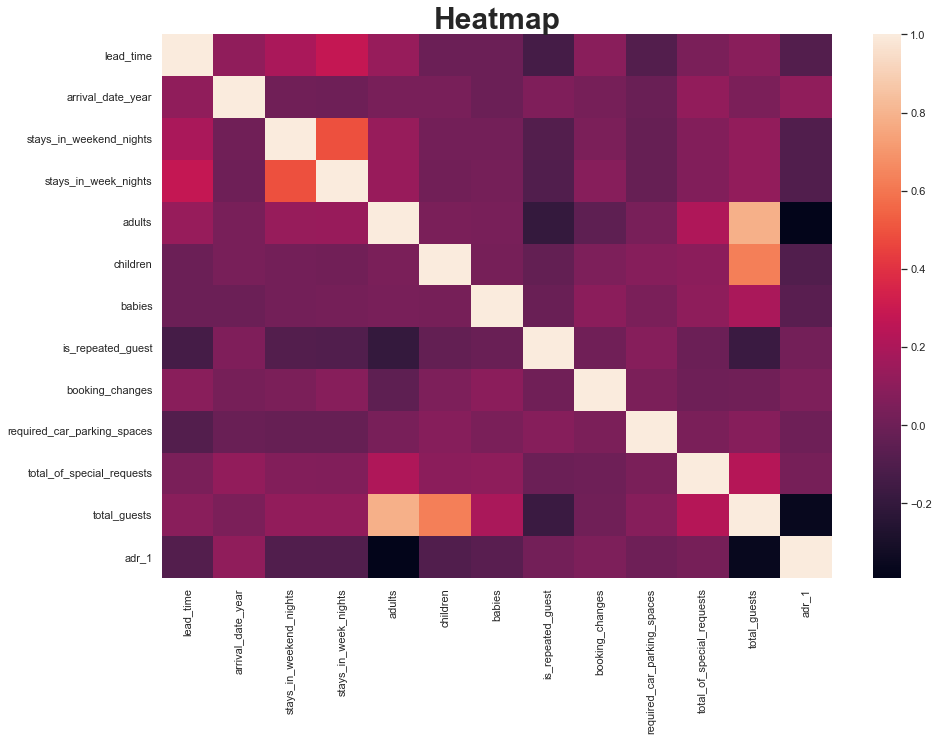

In [15]:
sns.set(rc = {'figure.figsize': (15,10)})
sns.heatmap(df_ht_lrp_mid.corr())
plt.title('Heatmap',fontsize=30,fontweight='bold')

### 더미변수 생성

In [16]:
# df_ht_lrp_fin = df_ht_lrp_mid.drop('country',axis=1)

# 더미화
df_lrp_fin = pd.get_dummies(data=df_ht_lrp_mid, 
                            columns=
                            ['hotel',
                             'arrival_date_year',
                             'arrival_date_month',
                             'meal',
                             'market_segment',
                             'distribution_channel',
                             'is_repeated_guest',
                             'assigned_room_type',
                             'booking_changes',
                             'deposit_type',
                             'customer_type',
                             'required_car_parking_spaces',
                             
                             ]
                            ,drop_first=True)

df_lrp_fin.columns.values

array(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'adults', 'children', 'babies', 'total_of_special_requests',
       'total_guests', 'adr_1', 'hotel_Resort Hotel',
       'arrival_date_year_2016', 'arrival_date_year_2017',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arrival_date_month_September', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'distribution_channel_Direct',
       'distribution_channel_GDS', 'distribution_channel_TA/TO',
       'distribution_channel_Undefined'

## 다중선형모델

In [17]:
from sklearn.model_selection import train_test_split
X = df_lrp_fin.drop('adr_1',axis=1)
y = df_lrp_fin['adr_1']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3, 
                                                    random_state=101)

In [18]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(X_train,y_train)

LinearRegression()

In [19]:
# print the intercept
print(lm.intercept_)

112.02226321316033


### coefficient 확인

In [20]:
# lm.coef_
# X.columns
coeff_df = pd.DataFrame(lm.coef_, X.columns,columns=['Coefficient'])
print(coeff_df.sort_values(by='Coefficient', ascending=False).head(10))
print(coeff_df.sort_values(by='Coefficient', ascending=True).head(10))

                              Coefficient
distribution_channel_GDS        35.613625
assigned_room_type_H            31.548673
assigned_room_type_G            26.020550
meal_FB                         25.223998
arrival_date_month_August       22.788702
meal_Undefined                  22.122882
arrival_date_month_July         18.520021
assigned_room_type_F            16.822670
arrival_date_month_September    16.779157
arrival_date_year_2017          16.722816
                               Coefficient
market_segment_Complementary    -49.427673
market_segment_Corporate        -22.117203
required_car_parking_spaces_8   -22.046501
market_segment_Groups           -19.523605
market_segment_Offline TA/TO    -19.123829
arrival_date_month_January      -17.715205
hotel_Resort Hotel              -17.346653
total_guests                    -16.148476
arrival_date_month_February     -14.032661
adults                          -12.540125


In [21]:
# predict
predictions = lm.predict(X_test)

### 예측결과 : scatter plot

adr_1이 100이 넘어가는 케이스부터 예측률이 떨어지는 점을 볼 수 있다. <br>
실제 호텔 비즈니스에서 사전에 확보하여 예측에 투입 가능한 변수들만 사용하여 모델을 구성한 점을 미루어볼 떄, 이정도의 오차는 허용범위이며, 
충분히 유의미한 adr예측이라고 생각된다. 

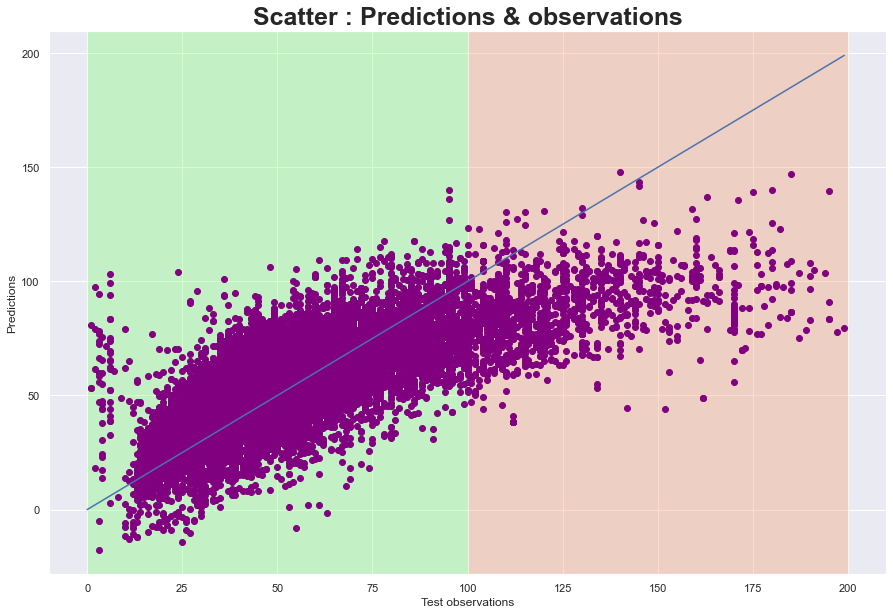

In [22]:

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)

## axes2
ax1.axvspan(0, 100, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(100, 200, facecolor='#f79159', alpha=0.3)

plt.scatter(x=y_test,y=predictions, c='purple')
plt.plot(range(200), range(200))
plt.title('Scatter : Predictions & observations',fontsize=25,fontweight='bold')
plt.xlabel('Test observations')
plt.ylabel('Predictions')
plt.show()

In [23]:
## compare the actual price with the predicted one in the test set

y_test1=y_test.to_frame()
y_test1['Predictions']=predictions
y_test1.head()

,adr_1,Predictions
95718,57.0,69.018238
18659,25.0,39.575182
32246,55.0,78.518949
86101,44.0,37.201705
20082,33.0,33.718968


### 예측결과 : Residual Histogram

잔차분포를 보여주는 그래프이다. 종모양으로 정규분포해 있다.

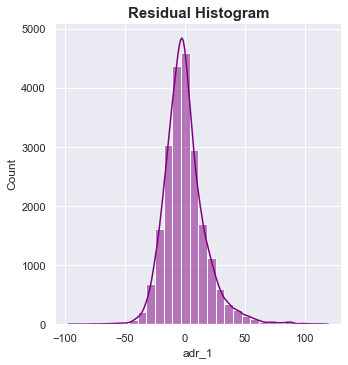

In [24]:
sns.displot((y_test-predictions),bins=30,color='purple',kde=True)
plt.title('Residual Histogram',fontsize=15,fontweight='bold')
plt.show()

In [25]:
# compute the erorrs and save them in the dataframe
y_test1['Error']=y_test1['Predictions']-y_test1['adr_1']
y_test1.head()

,adr_1,Predictions,Error
95718,57.0,69.018238,12.018238
18659,25.0,39.575182,14.575182
32246,55.0,78.518949,23.518949
86101,44.0,37.201705,-6.798295
20082,33.0,33.718968,0.718968


In [26]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 12.829927564167686
MSE: 317.4160262224553
RMSE: 17.816173164359828


### 정규성 검정 
1. qq plot - 결과 : 정규성을 어느정도 충족시키는 것으로 보인다.

Text(0.5, 1.0, 'QQ Plot')

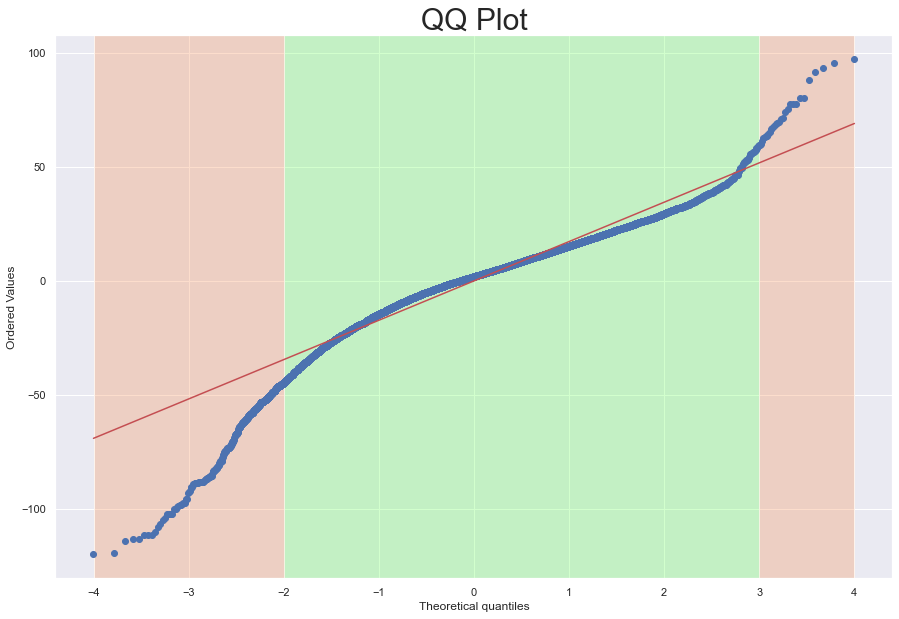

In [27]:
import scipy.stats as stats

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(1,1,1)
ax1.axvspan(-2,3, facecolor='#6cff5c', alpha=0.3)
ax1.axvspan(-4,-2, facecolor='#f79159', alpha=0.3)
ax1.axvspan(3,4, facecolor='#f79159', alpha=0.3)

stats.probplot(y_test1['Error'], plot=plt)

plt.title('QQ Plot', fontsize=30)